# Toy data
> Randomly-spaced points on a hyperbolic branch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.toy_data import generate_points_on_branch


In [3]:
# Generate 2 sets of points, for classification:

root = np.array([1.0, 0.0, 0.0])

points1 = generate_points_on_branch(
    root=root,
    direction=np.array([0.0, 1.0, 1.0]),
    num_points=100,
    noise_std=0.05,
)

points2 = generate_points_on_branch(
    root=root,
    direction=np.array([0.0, -1.0, 1.0]),
    num_points=100,
    noise_std=0.05,
)

data = np.vstack([points1, points2])
labels = np.hstack([np.zeros(100), np.ones(100)])


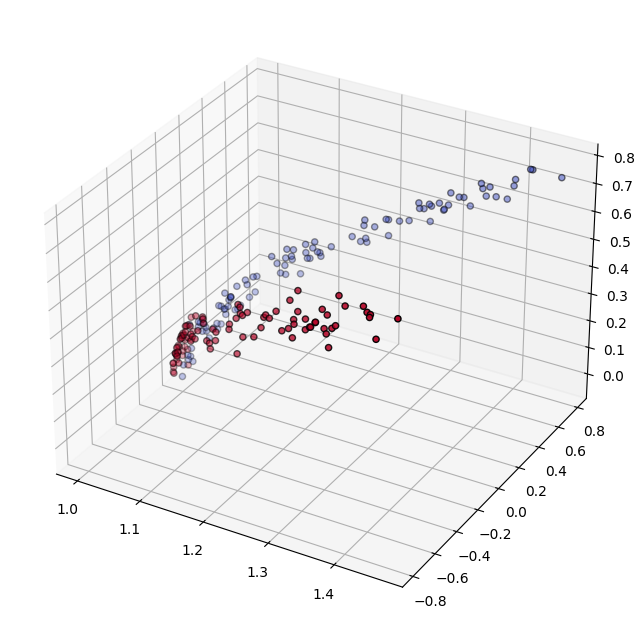

In [4]:
# Plot the points

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data[:, 0], data[:, 1], data[:, 2], c=labels, cmap="coolwarm", edgecolor="k"
)


In [36]:
# Try to classify using hyperbolic and regular decision trees

from sklearn.tree import DecisionTreeClassifier
from src.model import HyperbolicDecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

# Fit a regular decision tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Fit a hyperbolic decision tree
hdt = HyperbolicDecisionTreeClassifier()
hdt.fit(X_train, y_train)

# Compare scores
print(
    f"Regular decision tree accuracy: {accuracy_score(y_test, dt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy: {accuracy_score(y_test, hdt.predict(X_test)):.3f}",
    sep="\n",
)


Fitting node at depth 0
Got dim thetas scores
Finishing get_best_dim
145 theta 0.003556669880311336 dim 0 score 0.14323919234430704
Fitting node at depth 1
Fitting node at depth 1
Got dim thetas scores
Finishing get_best_dim
145 theta 0.003556669880311336 dim 0 score 0.14323919234430704
Fitting node at depth 2
Fitting node at depth 2
Got dim thetas scores
Finishing get_best_dim
145 theta 0.003556669880311336 dim 0 score 0.14323919234430704
Fitting node at depth 3
Fitting node at depth 3
Regular decision tree accuracy: 0.950
Hyperbolic decision tree accuracy: 0.475


In [37]:
hdt.predict(X_train)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [38]:
# Traverse the tree:

def traverse(node):
    if node.leaf:
        return [node]
    else:
        return traverse(node.left) + traverse(node.right)

for x in traverse(hdt.tree):
    print(x.depth, x.dim, x.theta, x.parent.id)

1 None None .
2 None None ._R
3 None None ._R_R
3 None None ._R_R
